<a href="https://colab.research.google.com/github/SarathSabu/Text-Analytics/blob/main/Fine_tuning_a_Transformers_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### © Copyright 2020 [George Mihaila](https://github.com/gmihaila).

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune Transformers in PyTorch Using Hugging Face Transformers   

## Finetune transformers models on classification task

<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gmihaila/ml_things/blob/master/notebooks/pytorch/finetune_transformers_pytorch.ipynb) &nbsp;
[![Generic badge](https://img.shields.io/badge/GitHub-Source-greensvg)](https://github.com/gmihaila/ml_things/blob/master/notebooks/pytorch/finetune_transformers_pytorch.ipynb)

<br>



## Info

This notebook is designed to use a pretrained transformers model and fine-tune it on classification task. The focus of this tutorial will be on the code itself and how to adjust it to your needs.

This notebook is using the [AutoClasses](https://huggingface.co/transformers/model_doc/auto.html) from
[transformer](https://github.com/huggingface/transformers) by [Hugging Face](https://huggingface.co/)  functionality.
This functionality can guess a model's configuration, tokenizer and architecture just by passing in the model's name. This allows us to reuse the code on a large number of transformers models!

<br>

## What should I know for this notebook?

I provided enough instructions and comments to be able to follow with just some Python coding knowledge.

Since I am using PyTorch to fine-tune our transformers models any knowledge on PyTorch is very useful. Knowing a little bit about the [transformers](https://github.com/huggingface/transformers) library helps too.

<br>

## How to use this notebook?

I built this notebook with reusability in mind. The way I load the dataset into the PyTorch  class is pretty standard and can be easily reused for any other dataset.

The only modifications needed to use your own dataset will be in reading in the dataset inside the PyTorch **Dataset** class under **Dataset and DataLoader** tab. The **DataLoader** will return a dictionary of batch inputs format so that it can be fed straight to the model using the statement: `outputs = model(**batch)`. *As long as this statement holds, the rest of the code will work!*

Basic parameters are defined under the **Imports** tab:
* `epochs` - will be used as the number of epochs to train the model. It is enough 2-3 epochs usually.
* `batch_size` - will be used as the batch size during training. The larger the batch the more RAM / GPU memory it will take. When running into Cuda Out Of Memory (OOM) errors just decrease batch size until the errors is solved. If the model is very large and GPU very weak it can lead up to `batch_size = 1`.
* `max_length` - I use this variable if I want to truncate text inputs to a shorter length than the maximum allowed word piece tokens sequence length. Maybe using a small amount of tokens is enough than using the whole amount. The shorter the sequence the faster it will train.
* `model_name_or_path` - This is where I put the transformer model I want to train. I added a table below showing all the models from Hugging Face Transformers that will work with this notebook! I always start with `bert-base-cased`.
* `labels_ids` - It is mostly the case that labels have a name / meaning. We need to associate each name / meaning with a number / id. I use this variable to create a dictionary that maps labels names to ids. This will be used later inside the PyTorch Dataset class.

<br>



## What transformers models work with this notebook?

There are rare cases where I use a different model than Bert when dealing with classification from text data. When there is a need to run a different transformer model architecture, which one would work with this code?

Since the name of the notebooks is *finetune_transformers* it should for with more than one type of transformers.

I ran this notebook across [all the pretrained models](https://huggingface.co/transformers/pretrained_models.html#pretrained-models) found on Hugging Face Transformer. This way you know ahead of time if the model you plan to use works with this code without any modifications.


The list of pretrained transformers models that work with this notebook can be found [here](https://github.com/gmihaila/ml_things/blob/master/notebooks/pytorch/finetune_transformers_pytorch_status_models.md#pretrained-models-that-work-with-finetune_transformers_pytorchipynb). There are **73 models that worked** and **33 models that failed to work** with this notebook.


<br>

## Dataset

This notebook will cover fine-tune transformers for a binary classification task. I will use the well known movies reviews positive - negative labeled [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

The description provided on the Stanford website:

*This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.*

**Why this dataset?** I believe is an easy to understand and use dataset for classification. I think sentiment data is always fun to work with.






# Downloads

Download the *Large Movie Review Dataset* and unzip it locally.


In [ ]:
# Download the dataset.
!wget -q -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# Unzip the dataset.
!tar -zxf /content/aclImdb_v1.tar.gz

# Installs

* **[transformers](https://github.com/huggingface/transformers)** library needs to be installed to use all the awesome code from Hugging Face. To get the latest version I will install it straight from GitHub.

* **[ml_things](https://github.com/gmihaila/ml_things)** library used for various machine learning related tasks. I created this library to reduce the amount of code I need to write for each machine learning project.


In [ ]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00


# Imports

Import all needed libraries for this notebook.

Declare parameters used for this notebook:

In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )


# Set seed for reproducibility,
set_seed(123)

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# Number of batch_size - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 64

# Padd or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'bert-base-cased'

# Dicitonary of labels and their id - this will be used to convert.
# String labels to number.
labels_ids = {'neg': 0, 'pos': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

# Helper Functions

I like to keep all Classes and functions that will be used in this notebook under this section to help maintain a clean look of the notebook:

* MovieReviewsDataset
* train
* validation

In [ ]:
class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens and where the text gets encoded using
  loaded tokenizer.

  This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

    use_tokenizer (:obj:`transformers.tokenization_?`):
        Transformer type tokenizer used to process raw text into numbers.

    labels_ids (:obj:`dict`):
        Dictionary to encode any labels names into numbers. Keys map to
        labels names and Values map to number associated to those labels.

    max_sequence_len (:obj:`int`, `optional`)
        Value to indicate the maximum desired sequence to truncate or pad text
        sequences. If no value is passed it will used maximum sequence size
        supported by the tokenizer and model.

  """

  def __init__(self, path, use_tokenizer, labels_ids, max_sequence_len=None):

    # Check if path exists.
    if not os.path.isdir(path):
      # Raise error if path is invalid.
      raise ValueError('Invalid `path` variable! Needs to be a directory')
    # Check max sequence length.
    max_sequence_len = use_tokenizer.max_len if max_sequence_len is None else max_sequence_len
    texts = []
    labels = []
    print('Reading partitions...')
    # Since the labels are defined by folders with data we loop
    # through each label.
    for label, label_id,  in tqdm(labels_ids.items()):
      sentiment_path = os.path.join(path, label)

      # Get all files from path.
      files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
      print('Reading %s files...' % label)
      # Go through each file and read its content.
      for file_name in tqdm(files_names):
        file_path = os.path.join(sentiment_path, file_name)

        # Read content.
        content = io.open(file_path, mode='r', encoding='utf-8').read()
        # Fix any unicode issues.
        content = fix_text(content)
        # Save content.
        texts.append(content)
        # Save encode labels.
        labels.append(label_id)

    # Number of exmaples.
    self.n_examples = len(labels)
    # Use tokenizer on texts. This can take a while.
    print('Using tokenizer on all texts. This can take a while...')
    self.inputs = use_tokenizer(texts, add_special_tokens=True, truncation=True, padding=True, return_tensors='pt',  max_length=max_sequence_len)
    # Get maximum sequence length.
    self.sequence_len = self.inputs['input_ids'].shape[-1]
    print('Texts padded or truncated to %d length!' % self.sequence_len)
    # Add labels.
    self.inputs.update({'labels':torch.tensor(labels)})
    print('Finished!\n')

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """

    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.

    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
      It holddes the statement `model(**Returned Dictionary)`.

    """

    return {key: self.inputs[key][item] for key in self.inputs.keys()}



def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here:
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

# Load Model and Tokenizer

Loding the three esential parts of pretrained transformers: configuration, tokenizer and model. We also need to load model to the device we're planning to use (GPU / CPU).

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                          num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                                           config=model_config)

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading tokenizer...
Loading model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


# Dataset and DataLoader

Create the PyTorch Dataset and DataLoader objects that will be used to feed data into our model.

In [ ]:
print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = MovieReviewsDataset(path='/content/aclImdb/train',
                               use_tokenizer=tokenizer,
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print('Dealing with ...')
# Create pytorch dataset.
valid_dataset =  MovieReviewsDataset(path='/content/aclImdb/test',
                               use_tokenizer=tokenizer,
                               labels_ids=labels_ids,
                               max_sequence_len=max_length)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Reading partitions...


  0%|          | 0/2 [00:00<?, ?it/s]

Reading neg files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Reading pos files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `train_dataset` with 25000 examples!
Created `train_dataloader` with 391 batches!
Dealing with ...
Reading partitions...


  0%|          | 0/2 [00:00<?, ?it/s]

Reading neg files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Reading pos files...


  0%|          | 0/12500 [00:00<?, ?it/s]

Using tokenizer on all texts. This can take a while...
Texts padded or truncated to 60 length!
Finished!

Created `valid_dataset` with 25000 examples!
Created `eval_dataloader` with 391 batches!


# Train

Create optimizer and scheduler use by PyTorch in training.

Loop through the number of defined epochs and call the **train** and **validation** functions.

Outputs similar info after each epoch as in Keras: *train_loss:  - val_loss:  - train_acc: - valid_acc*.

After training, plot train and validation loss and accuracy curves to check how the training went.

In [ ]:
!pip install torch-optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

Epoch


  0%|          | 0/1 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/391 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/391 [00:00<?, ?it/s]

  train_loss: 0.46433 - val_loss: 0.39166 - train_acc: 0.76816 - valid_acc: 0.81464



/usr/local/lib/python3.11/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


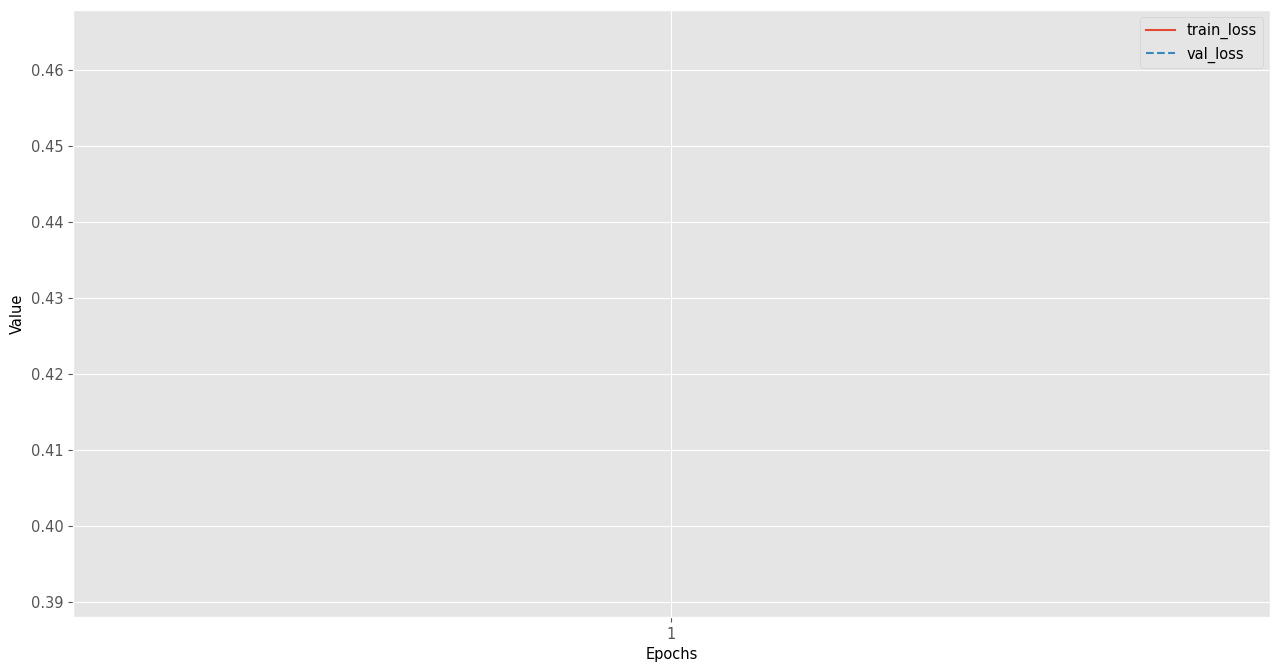

/usr/local/lib/python3.11/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


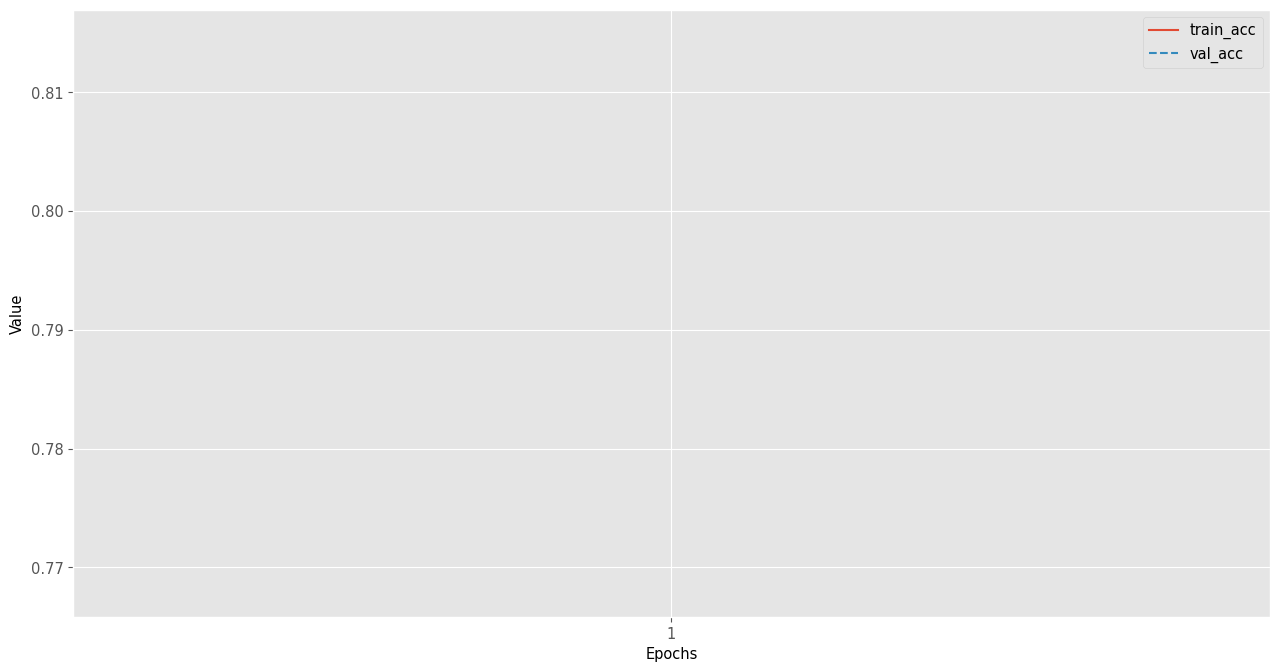

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
import torch_optimizer as optim
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps = 1e-8)


# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

# Evaluate

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

  0%|          | 0/391 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         neg       0.81      0.82      0.82     12500
         pos       0.82      0.81      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000

Normalized confusion matrix


/usr/local/lib/python3.11/dist-packages/ml_things/plot_functions.py:676: DeprecationWarning: `magnify` needs to have value in [0,1]! `3` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


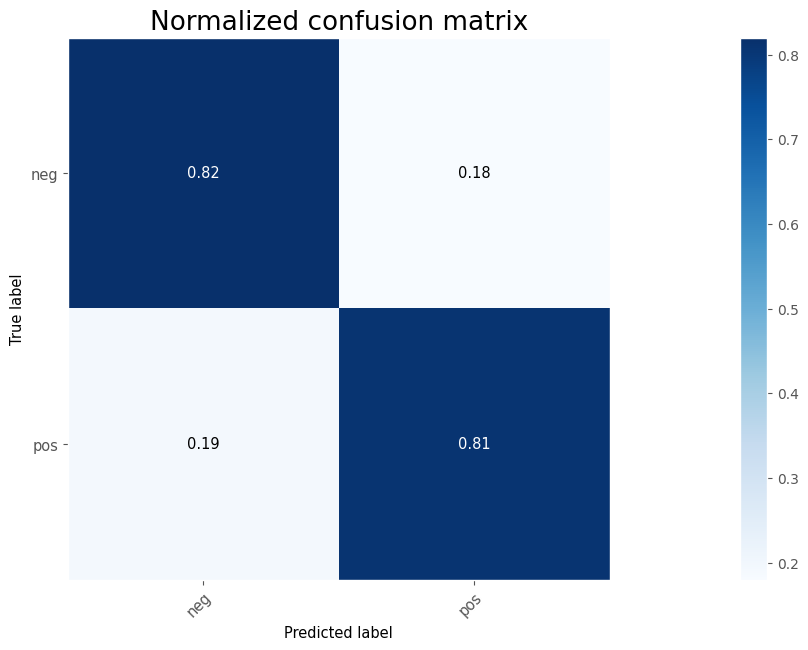

In [ ]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=3,
                      );